# TP Final

Segunda Parte

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

from torch.utils.tensorboard import SummaryWriter

El Dataset que voy a usar es 

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

Es un dataset de cartas de Poker 224 X 224 X 3 en formato jpg. \
Hay solo una carta en cada imagen y ocupa al menos el 50%. \
Hay 7624 imagens en entrenamiento, 265 en Test y 265 en validacion. \
La idea es Entrenar un modelo de clasificacion que a partir de una imagen de una carta pueda decirnos cual es. \
Yo ya tengo el directorio bajado localmente.


Cargo los datos e imprimo una imagen de cada clase etiquetada

In [3]:
# Definiciones iniciales
CANTIDAD_CLASES = 53
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

In [4]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='data_Cards/test', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

### Resnet
Defino un modelo resnet en el cual reemplazo la capa Fully Coneected por una con un numero de salidas igual \
al numero de clases de mi dataset

In [5]:
resnet_model = torchvision.models.resnet50()
last_layer_in_features = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

if torch.cuda.is_available():
    resnet_model.to("cuda")
torchsummary.summary(resnet_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [6]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None, checkpoint_fpath=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    # Esto lo agrego para poder usar un modelo previamente entrenado y seguir desde ahí.
    if checkpoint_fpath:
        checkpoint = torch.load(checkpoint_fpath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to('cuda')

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

Entreno el modelo

In [8]:
noaug_resnet50_model = torchvision.models.resnet50()
last_layer_in_features = noaug_resnet50_model.fc.in_features
noaug_resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

noaug_resnet50_optimizer = torch.optim.Adam(noaug_resnet50_model.parameters(), lr=0.0001)
noaug_resnet50_loss = torch.nn.CrossEntropyLoss()
noaug_resnet50_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_resnet50_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_resnet50_writer = {"train": SummaryWriter(log_dir="data_cards/noaug_resnet50_train"),
                "valid": SummaryWriter(log_dir="data_cards/noaug_resnet50_valid")}

history = train(noaug_resnet50_model,
                noaug_resnet50_optimizer,
                noaug_resnet50_loss,
                noaug_resnet50_metric,
                noaug_resnet50_data,
                20,
                noaug_resnet50_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': noaug_resnet50_model.state_dict(),
        'optimizer': noaug_resnet50_optimizer.state_dict(),
}
savepath='checkpoint.noaug_resnet50_20'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 3.533461 - Train Accuracy 0.082767 - Valid Loss 3.377501 - Valid Accuracy 0.121914
Epoch: 2/20 - Train loss 2.754008 - Train Accuracy 0.211820 - Valid Loss 2.521251 - Valid Accuracy 0.257716
Epoch: 3/20 - Train loss 2.265259 - Train Accuracy 0.332636 - Valid Loss 1.940862 - Valid Accuracy 0.365355
Epoch: 4/20 - Train loss 1.840739 - Train Accuracy 0.464566 - Valid Loss 1.727330 - Valid Accuracy 0.471065
Epoch: 5/20 - Train loss 1.524973 - Train Accuracy 0.564331 - Valid Loss 1.342638 - Valid Accuracy 0.610725
Epoch: 6/20 - Train loss 1.271303 - Train Accuracy 0.642259 - Valid Loss 1.508605 - Valid Accuracy 0.581019
Epoch: 7/20 - Train loss 1.062592 - Train Accuracy 0.698745 - Valid Loss 1.417346 - Valid Accuracy 0.600309
Epoch: 8/20 - Train loss 0.829551 - Train Accuracy 0.759937 - Valid Loss 1.256118 - Valid Accuracy 0.676698
Epoch: 9/20 - Train loss 0.663313 - Train Accuracy 0.815115 - Valid Loss 1.174597 - Valid Accuracy 0.712963
Epoch: 10/20 - Train loss 0.

Realizo gráficas del resultado del entrenamiento para visualizar el comportamiento de las métricas a lo largo de las epocas.

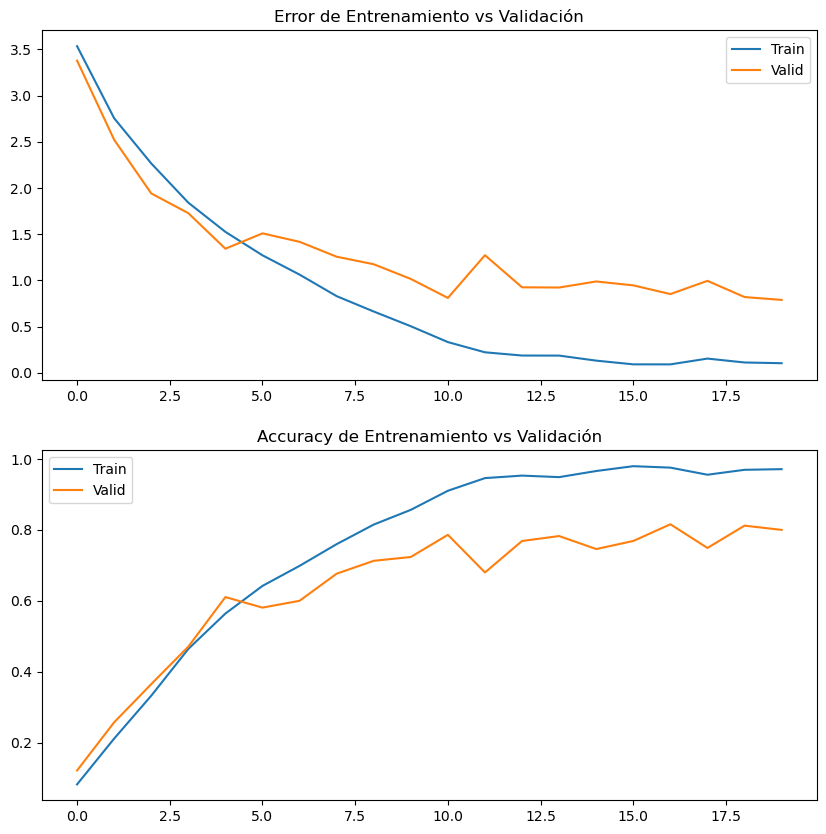

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

La performance mejora mucho con respecto a la red convolucional simple de antes, pero igual hay un sobreajuste

### Resnet con Data Augmentation

In [7]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.8, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=aug_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='data_Cards/valid', transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=64, shuffle=True)

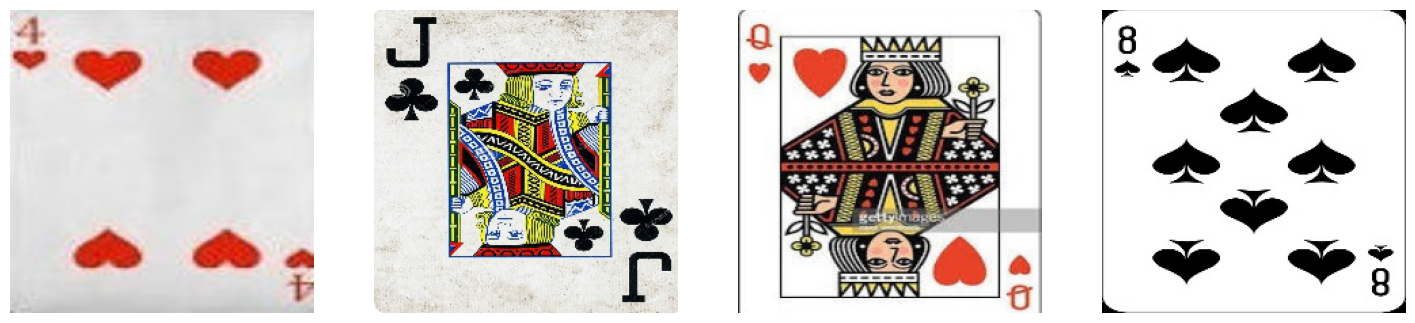

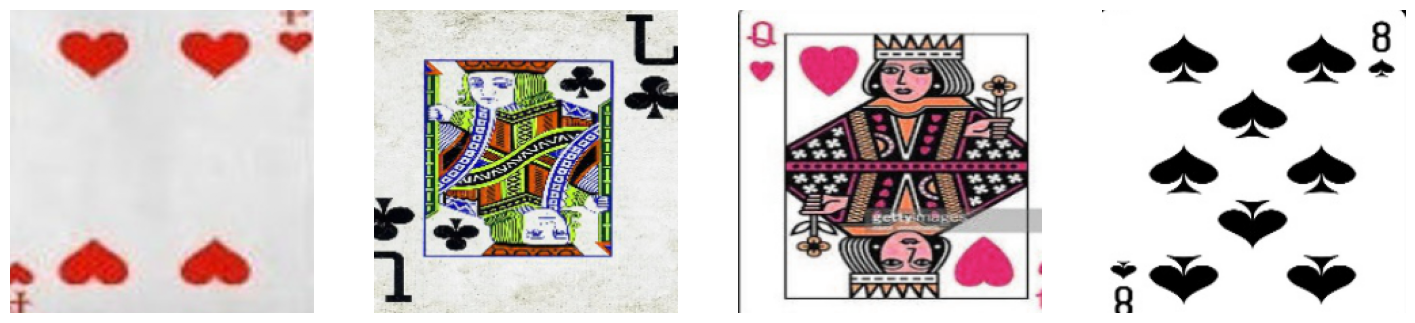

In [10]:
images_ids = np.random.randint(low=0, high=len(train_set), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

loss=CrossEntropyLoss
lr=0.0001
optim=adam

In [11]:
aug_resnet50_model = torchvision.models.resnet50()
last_layer_in_features = aug_resnet50_model.fc.in_features
aug_resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

aug_resnet50_optimizer = torch.optim.Adam(aug_resnet50_model.parameters(), lr=0.0001)
aug_resnet50_loss = torch.nn.CrossEntropyLoss()
aug_resnet50_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_resnet50_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_resnet50_writer = {"train": SummaryWriter(log_dir="data_cards/aug_resnet50_train"),
                "valid": SummaryWriter(log_dir="data_cards/aug_resnet50_valid")}

history = train(aug_resnet50_model,
                aug_resnet50_optimizer,
                aug_resnet50_loss,
                aug_resnet50_metric,
                aug_resnet50_data,
                20,
                aug_resnet50_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': aug_resnet50_model.state_dict(),
        'optimizer': aug_resnet50_optimizer.state_dict(),
}
savepath='checkpoint.aug_resnet50_20'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 3.700177 - Train Accuracy 0.061849 - Valid Loss 3.814839 - Valid Accuracy 0.062500
Epoch: 2/20 - Train loss 2.981884 - Train Accuracy 0.169401 - Valid Loss 2.921457 - Valid Accuracy 0.184722
Epoch: 3/20 - Train loss 2.596859 - Train Accuracy 0.250000 - Valid Loss 2.663178 - Valid Accuracy 0.253819
Epoch: 4/20 - Train loss 2.314887 - Train Accuracy 0.330469 - Valid Loss 2.161395 - Valid Accuracy 0.382639
Epoch: 5/20 - Train loss 2.065099 - Train Accuracy 0.425391 - Valid Loss 1.868836 - Valid Accuracy 0.463542
Epoch: 6/20 - Train loss 1.844425 - Train Accuracy 0.498698 - Valid Loss 1.779896 - Valid Accuracy 0.473264
Epoch: 7/20 - Train loss 1.687615 - Train Accuracy 0.532682 - Valid Loss 2.049330 - Valid Accuracy 0.407639
Epoch: 8/20 - Train loss 1.542702 - Train Accuracy 0.568620 - Valid Loss 1.548277 - Valid Accuracy 0.501389
Epoch: 9/20 - Train loss 1.444843 - Train Accuracy 0.598307 - Valid Loss 1.249287 - Valid Accuracy 0.629861
Epoch: 10/20 - Train loss 1.

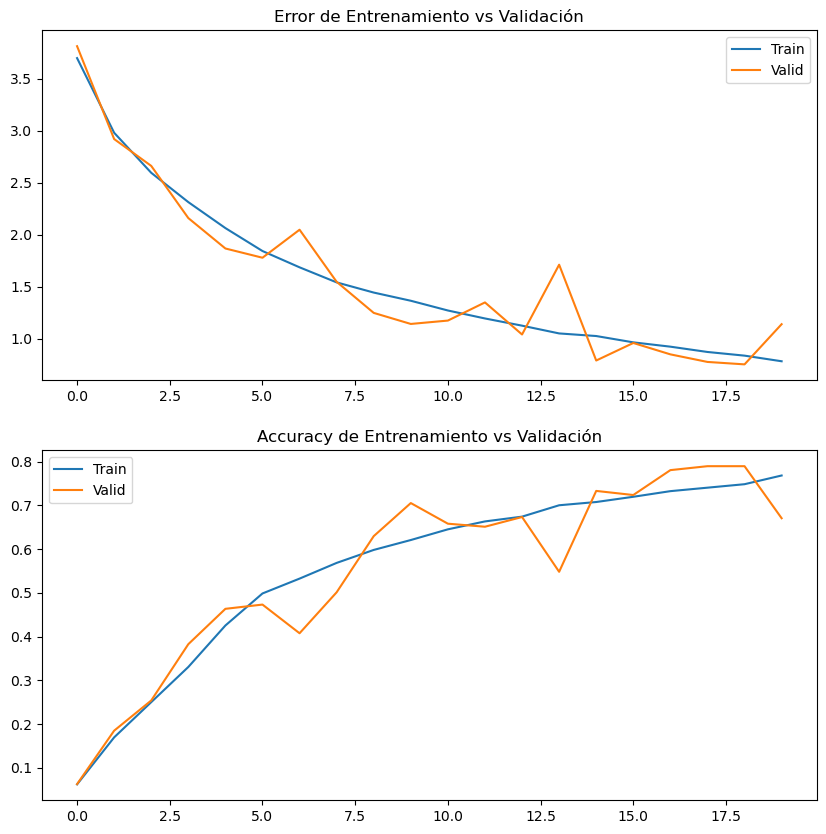

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Por ahora con data agumentation no sobreajusta. \
Meto 20 épocas más desde el checkpoint

In [14]:
aug_resnet50_model = torchvision.models.resnet50()
last_layer_in_features = aug_resnet50_model.fc.in_features
aug_resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

aug_resnet50_optimizer = torch.optim.Adam(aug_resnet50_model.parameters(), lr=0.0001)
aug_resnet50_loss = torch.nn.CrossEntropyLoss()
aug_resnet50_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_resnet50_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_resnet50_writer = {"train": SummaryWriter(log_dir="data_cards/aug_resnet50_train"),
                "valid": SummaryWriter(log_dir="data_cards/aug_resnet50_valid")}

history2 = train(aug_resnet50_model,
                aug_resnet50_optimizer,
                aug_resnet50_loss,
                aug_resnet50_metric,
                aug_resnet50_data,
                20,
                aug_resnet50_writer,
                'checkpoint.aug_resnet50_20')

state = {
        'epoch': 20,
        'state_dict': aug_resnet50_model.state_dict(),
        'optimizer': aug_resnet50_optimizer.state_dict(),
}
savepath='checkpoint.aug_resnet50_40'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 0.757400 - Train Accuracy 0.774870 - Valid Loss 0.790651 - Valid Accuracy 0.765278
Epoch: 2/20 - Train loss 0.722253 - Train Accuracy 0.781901 - Valid Loss 0.857935 - Valid Accuracy 0.745833
Epoch: 3/20 - Train loss 0.679866 - Train Accuracy 0.792188 - Valid Loss 1.556139 - Valid Accuracy 0.627083
Epoch: 4/20 - Train loss 0.658130 - Train Accuracy 0.803385 - Valid Loss 0.761262 - Valid Accuracy 0.777431
Epoch: 5/20 - Train loss 0.623285 - Train Accuracy 0.810547 - Valid Loss 0.632246 - Valid Accuracy 0.825000
Epoch: 6/20 - Train loss 0.583150 - Train Accuracy 0.821745 - Valid Loss 0.552538 - Valid Accuracy 0.868750
Epoch: 7/20 - Train loss 0.540458 - Train Accuracy 0.836328 - Valid Loss 0.901693 - Valid Accuracy 0.779861
Epoch: 8/20 - Train loss 0.499778 - Train Accuracy 0.854036 - Valid Loss 0.581772 - Valid Accuracy 0.865625
Epoch: 9/20 - Train loss 0.494013 - Train Accuracy 0.845182 - Valid Loss 0.748298 - Valid Accuracy 0.777083
Epoch: 10/20 - Train loss 0.

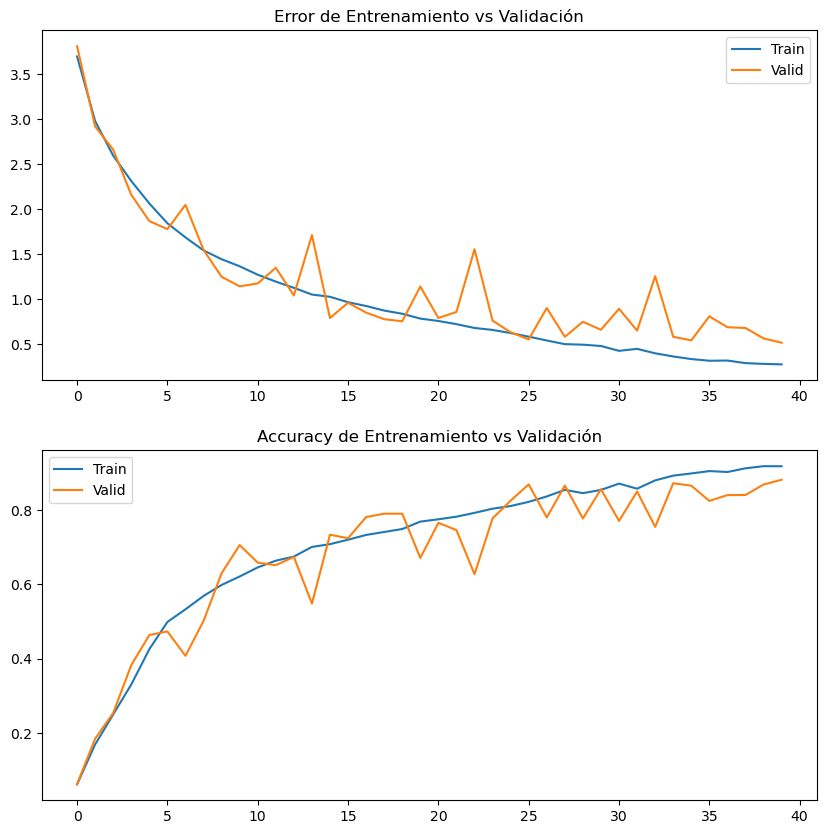

In [40]:
history_full = dict()
history_full['train_loss'] = history['train_loss'] + history2['train_loss']
history_full['valid_loss'] = history['valid_loss'] + history2['valid_loss']
history_full['train_acc'] = history['train_acc'] + history2['train_acc']
history_full['valid_acc'] = history['valid_acc'] + history2['valid_acc']


fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_full["train_loss"])
axs[0].plot(history_full["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history_full["train_acc"])
axs[1].plot(history2["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Con Resnet50 con Data augmentation alcanzo en 40 epocas un 88% de accuracy en Validacion. \
No parece haber Sobreajuste. Incluso podría agregar más épocas

### Resnet 50 con otras Data augmentations

In [39]:
aug_data_transforms2 = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        # torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=(0,180)),
                        torchvision.transforms.RandomPerspective(0.4),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.8, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.3, hue=0.3),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set2 = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=aug_data_transforms2)
aug_valid_set = torchvision.datasets.ImageFolder(root='data_Cards/valid', transform=data_transforms)

aug_train_loader2 = torch.utils.data.DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=64, shuffle=True)

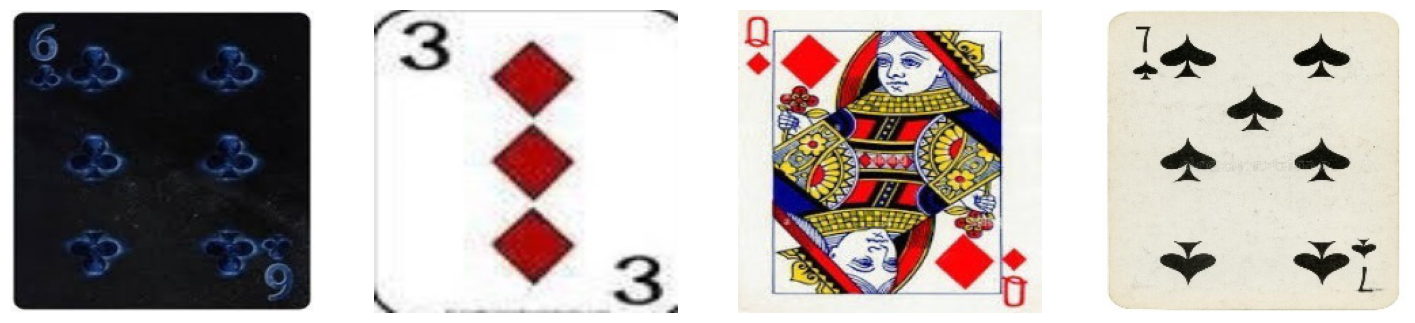

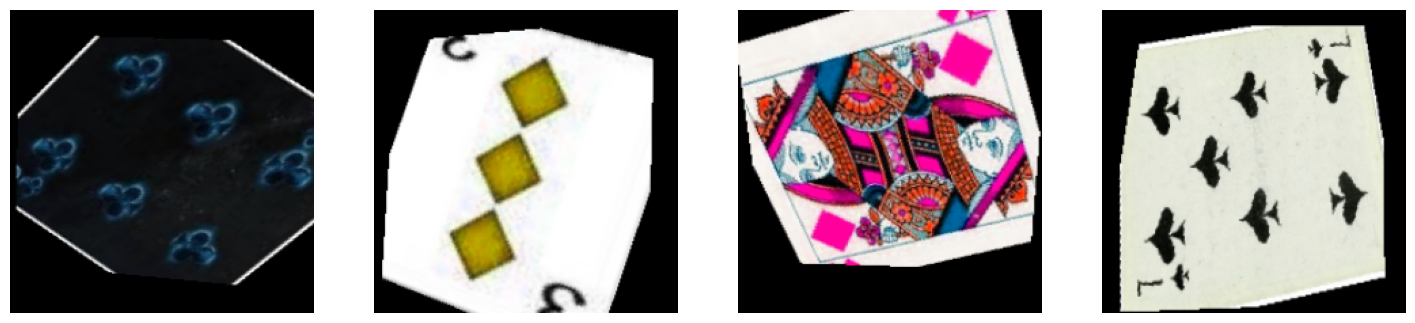

In [44]:
images_ids = np.random.randint(low=0, high=len(train_set), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set2[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [45]:
aug_resnet50_model = torchvision.models.resnet50()
last_layer_in_features = aug_resnet50_model.fc.in_features
aug_resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

aug_resnet50_optimizer = torch.optim.Adam(aug_resnet50_model.parameters(), lr=0.0001)
aug_resnet50_loss = torch.nn.CrossEntropyLoss()
aug_resnet50_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_resnet50_data = {"train": aug_train_loader2, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_resnet50_writer = {"train": SummaryWriter(log_dir="data_cards/aug_resnet50_2_train"),
                "valid": SummaryWriter(log_dir="data_cards/aug_resnet50_valid_2")}

history_resnet_aug_2 = train(aug_resnet50_model,
                aug_resnet50_optimizer,
                aug_resnet50_loss,
                aug_resnet50_metric,
                aug_resnet50_data,
                40,
                aug_resnet50_writer,
                None)

state = {
        'epoch': 40,
        'state_dict': aug_resnet50_model.state_dict(),
        'optimizer': aug_resnet50_optimizer.state_dict(),
}
savepath='checkpoint.aug_resnet50_2_40'
torch.save(state,savepath)

Epoch: 1/40 - Train loss 3.620970 - Train Accuracy 0.065234 - Valid Loss 3.617822 - Valid Accuracy 0.103472
Epoch: 2/40 - Train loss 3.014562 - Train Accuracy 0.163151 - Valid Loss 2.987330 - Valid Accuracy 0.175694
Epoch: 3/40 - Train loss 2.640443 - Train Accuracy 0.243229 - Valid Loss 2.496228 - Valid Accuracy 0.253819
Epoch: 4/40 - Train loss 2.356540 - Train Accuracy 0.311458 - Valid Loss 2.171339 - Valid Accuracy 0.259722
Epoch: 5/40 - Train loss 2.117113 - Train Accuracy 0.392578 - Valid Loss 1.981168 - Valid Accuracy 0.417014
Epoch: 6/40 - Train loss 1.925608 - Train Accuracy 0.447656 - Valid Loss 1.752188 - Valid Accuracy 0.486806
Epoch: 7/40 - Train loss 1.771743 - Train Accuracy 0.493490 - Valid Loss 1.714153 - Valid Accuracy 0.504861
Epoch: 8/40 - Train loss 1.615438 - Train Accuracy 0.538151 - Valid Loss 1.765927 - Valid Accuracy 0.463542
Epoch: 9/40 - Train loss 1.499349 - Train Accuracy 0.577214 - Valid Loss 2.145120 - Valid Accuracy 0.486111
Epoch: 10/40 - Train loss 1.

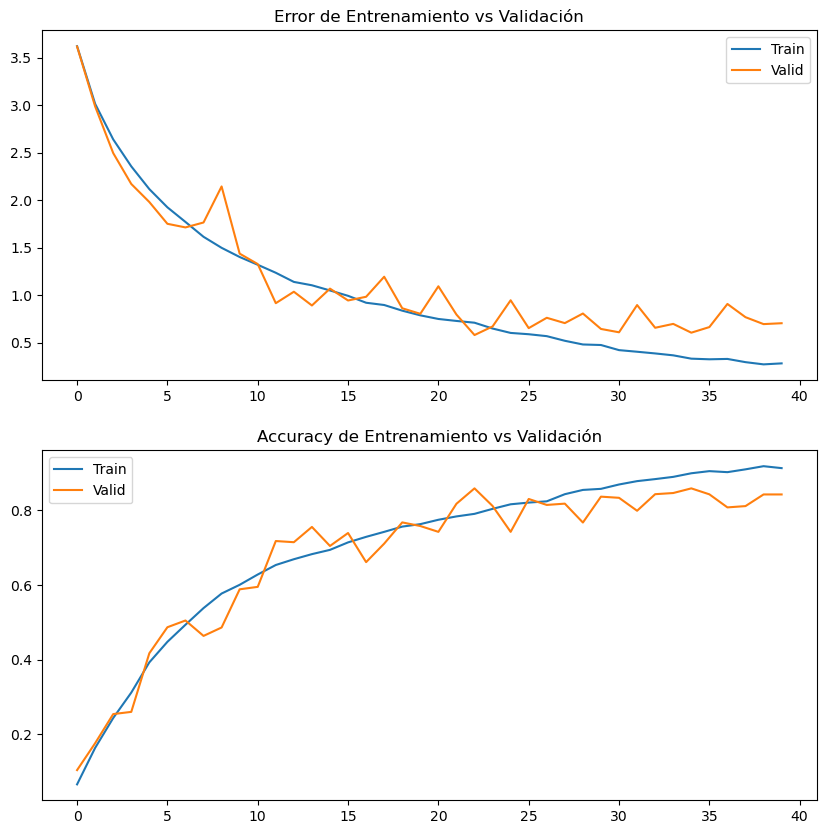

: 

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_resnet_aug_2["train_loss"])
axs[0].plot(history_resnet_aug_2["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history_resnet_aug_2["train_acc"])
axs[1].plot(history_resnet_aug_2["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Transfer Learning

In [10]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V1
transforms = weights.transforms()




In [11]:
tl_aug_resnet50_model = torchvision.models.resnet50(weights=weights)
## Congelo capas
for param in tl_aug_resnet50_model.parameters():
    param.requires_grad = False
last_layer_in_features = tl_aug_resnet50_model.fc.in_features
tl_aug_resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

tl_aug_resnet50_optimizer = torch.optim.Adam(tl_aug_resnet50_model.parameters(), lr=0.0001)
tl_aug_resnet50_loss = torch.nn.CrossEntropyLoss()
tl_aug_resnet50_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
tl_aug_resnet50_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

tl_aug_resnet50_writer = {"train": SummaryWriter(log_dir="data_cards/tl_aug_resnet50_train"),
                "valid": SummaryWriter(log_dir="data_cards/tl_aug_resnet50_valid")}

history_resnet_tl_aug_2 = train(tl_aug_resnet50_model,
                tl_aug_resnet50_optimizer,
                tl_aug_resnet50_loss,
                tl_aug_resnet50_metric,
                tl_aug_resnet50_data,
                20,
                tl_aug_resnet50_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': tl_aug_resnet50_model.state_dict(),
        'optimizer': tl_aug_resnet50_optimizer.state_dict(),
}
savepath='checkpoint.tl_aug_resnet50_20'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 3.715215 - Train Accuracy 0.092318 - Valid Loss 3.335460 - Valid Accuracy 0.223264
Epoch: 2/20 - Train loss 3.240984 - Train Accuracy 0.227344 - Valid Loss 3.038936 - Valid Accuracy 0.222917
Epoch: 3/20 - Train loss 2.948361 - Train Accuracy 0.292839 - Valid Loss 2.721271 - Valid Accuracy 0.260417
Epoch: 4/20 - Train loss 2.743582 - Train Accuracy 0.338932 - Valid Loss 2.656912 - Valid Accuracy 0.301042
Epoch: 5/20 - Train loss 2.592464 - Train Accuracy 0.368229 - Valid Loss 2.454246 - Valid Accuracy 0.323264
Epoch: 6/20 - Train loss 2.475211 - Train Accuracy 0.398698 - Valid Loss 2.483801 - Valid Accuracy 0.272222
Epoch: 7/20 - Train loss 2.380104 - Train Accuracy 0.417057 - Valid Loss 2.312956 - Valid Accuracy 0.313194
Epoch: 8/20 - Train loss 2.303780 - Train Accuracy 0.432031 - Valid Loss 2.239955 - Valid Accuracy 0.370139
Epoch: 9/20 - Train loss 2.233356 - Train Accuracy 0.455339 - Valid Loss 2.226172 - Valid Accuracy 0.398611
Epoch: 10/20 - Train loss 2.

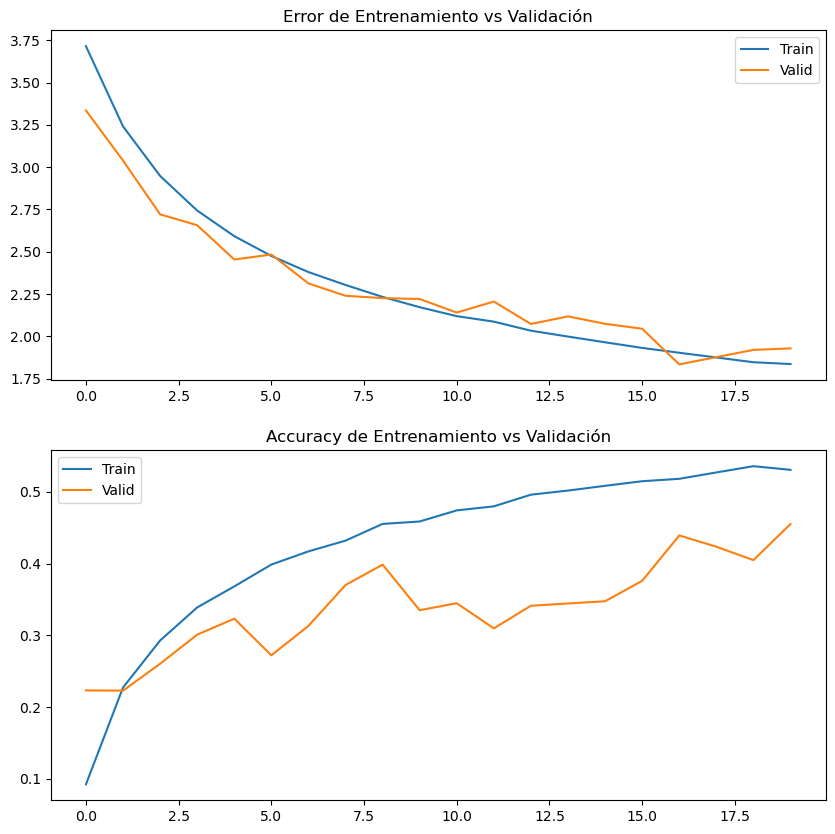

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_resnet_tl_aug_2["train_loss"])
axs[0].plot(history_resnet_tl_aug_2["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history_resnet_tl_aug_2["train_acc"])
axs[1].plot(history_resnet_tl_aug_2["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])